This notebook demonstrates using the apoc `TableRowClasifer`

In [1]:
import apoc
import numpy as np
from numpy.random import default_rng
from skimage import draw
from skimage.measure import regionprops_table
import pyclesperanto_prototype as cle

In [2]:
cle.select_device()

<pthread-Intel(R) Xeon(R) W-2125 CPU @ 4.00GHz on Platform: Portable Computing Language (2 refs)>

In [3]:
def get_square_indices(center_row, center_column, half_width=5):
    """Get the indices to fill in a square"""
    start = np.array([center_row, center_column]) - half_width
    extent = (2 * half_width, 2 * half_width)
    return draw.rectangle(start, extent=extent)


def get_circle_indices(center_row, center_column, half_width=5):
    """Get the indices to fill in a circle"""
    center = (center_row, center_column)
    radius = half_width
    return draw.disk(center, radius)


In [4]:
# create a label image with randomly placed squares and circles
rng = default_rng(42)

label_image = np.zeros((200, 200), dtype=np.uint16)

label_index = 1
ground_truth = []
for center_row in np.arange(10, 200, 20):
    for center_column in np.arange(10, 200, 20):
        shape_type = rng.choice(["square", "circle"])
        if shape_type == "square":
            shape_function = get_square_indices
            ground_truth.append(1)
        else:
            shape_function = get_circle_indices
            ground_truth.append(2)
        shape_rows, shape_columns = shape_function(center_row, center_column, half_width=5)
        
        label_image[shape_rows, shape_columns] = label_index
    
        label_index += 1

ground_truth = np.asarray(ground_truth)

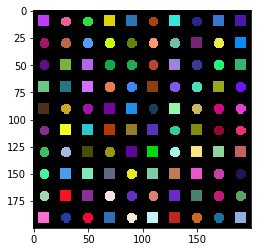

In [5]:
# view the label image
cle.imshow(label_image, labels=True)

In [6]:
# measure the  using skimage's regionprops_table function
measurement_table = regionprops_table(label_image, properties=("label", "area", "perimeter"))
labels = measurement_table.pop("label")

In [7]:
# extract the first 50 measurements to use as training
measurements_training = {key: values[0:50] for key, values in measurement_table.items()}
ground_truth_training = ground_truth[0:50]

# create the classifier and train it
cl_filename = "shape_classifier.model.cl"
apoc.erase_classifier(cl_filename)
classifier = apoc.TableRowClassifier(cl_filename)
classifier.train(measurements_training, ground_truth_training)


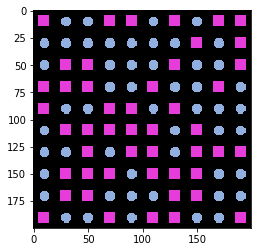

In [8]:
# predict on the full table
prediction = classifier.predict(measurement_table)

# create an image where the objects are colored by the predicted shape
shape_image = np.zeros_like(label_image)
for label_index, predicted_shape in zip(labels, prediction):
    shape_image[label_image == label_index] = predicted_shape

cle.imshow(shape_image, labels=True)